In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from osgeo import gdal    ## used to read images in memory

import tensorflow as tf

################################################################
## Storing and timing Models
import pickle
from joblib import dump,load
import time

################################################################
# Custom functions from lib.py
from lib import dataExtract, dataStack, indicesFromDataStack, \
                stochasticPCAFromDataStack, stochasticICAFromDataStack, \
                stackToImage, featuresCompute, \
                vectorStackToImage

################################################################
import warnings
warnings.filterwarnings("ignore")

################################################################

### Extract Data

In [2]:
colNames = ['coastal','blue','green','yellow','red','red edge','near IR1', 'near IR2','AGL','CLS']
rawDataTrain = dataExtract(foldername='train')

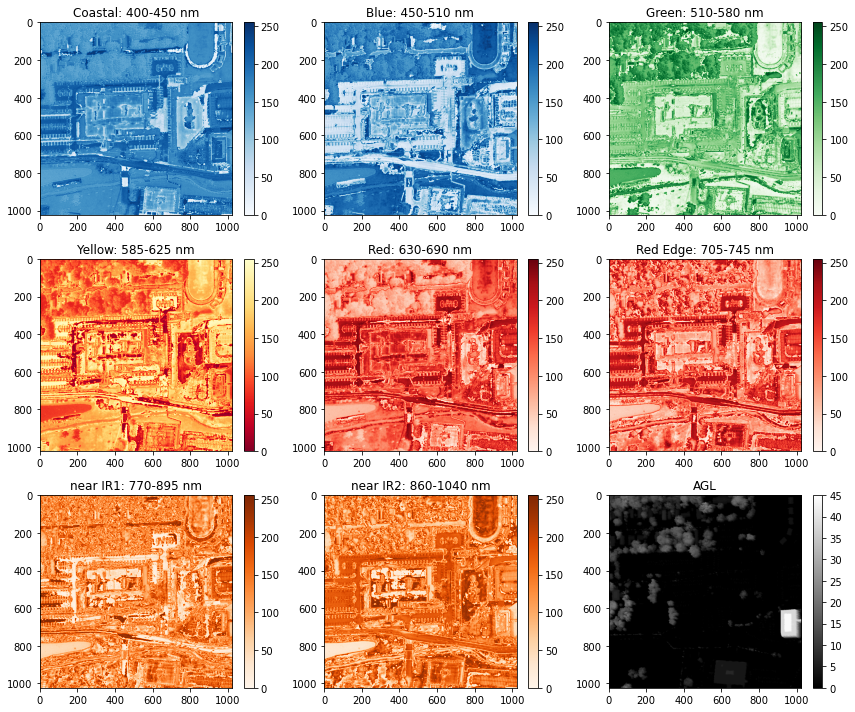

In [3]:
imgIdx = 1   ## index of image to plot

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(12,10))
img = ax[0][0].imshow(rawDataTrain['MSI'][imgIdx][0].astype(np.uint8), cmap='Blues'); ax[0][0].set_title('Coastal: 400-450 nm'); fig.colorbar(img, ax=ax[0][0], fraction=0.05)
img = ax[0][1].imshow(rawDataTrain['MSI'][imgIdx][1].astype(np.uint8), cmap='Blues'); ax[0][1].set_title('Blue: 450-510 nm'); fig.colorbar(img, ax=ax[0][1], fraction=0.05)
img = ax[0][2].imshow(rawDataTrain['MSI'][imgIdx][2].astype(np.uint8), cmap='Greens'); ax[0][2].set_title('Green: 510-580 nm'); fig.colorbar(img, ax=ax[0][2], fraction=0.05)
img = ax[1][0].imshow(rawDataTrain['MSI'][imgIdx][3].astype(np.uint8), cmap='YlOrRd_r'); ax[1][0].set_title('Yellow: 585-625 nm'); fig.colorbar(img, ax=ax[1][0], fraction=0.05)
img = ax[1][1].imshow(rawDataTrain['MSI'][imgIdx][4].astype(np.uint8), cmap='Reds'); ax[1][1].set_title('Red: 630-690 nm'); fig.colorbar(img, ax=ax[1][1], fraction=0.05)
img = ax[1][2].imshow(rawDataTrain['MSI'][imgIdx][5].astype(np.uint8), cmap='Reds'); ax[1][2].set_title('Red Edge: 705-745 nm'); fig.colorbar(img, ax=ax[1][2], fraction=0.05)
img = ax[2][0].imshow(rawDataTrain['MSI'][imgIdx][6].astype(np.uint8), cmap='Oranges'); ax[2][0].set_title('near IR1: 770-895 nm'); fig.colorbar(img, ax=ax[2][0], fraction=0.05)
img = ax[2][1].imshow(rawDataTrain['MSI'][imgIdx][7].astype(np.uint8), cmap='Oranges'); ax[2][1].set_title('near IR2: 860-1040 nm'); fig.colorbar(img, ax=ax[2][1], fraction=0.05)
img = ax[2][2].imshow(rawDataTrain['AGL'][imgIdx].astype(np.uint8), cmap='gray'); ax[2][2].set_title('AGL'); fig.colorbar(img, ax=ax[2][2], fraction=0.05)

fig.tight_layout()
plt.savefig('./plots/rawData.svg')


## Features Compute

In [4]:
dataTrain = dataStack(rawDataTrain)
## Compute features
dataTrain = pd.DataFrame( np.array(dataTrain) , columns=colNames )
dataTrain = featuresCompute(dataTrain, numPCA=3, numICA=3 )
print(f'Feature Names:\n{dataTrain.columns}')

Computed Principal Components
Computed Independent Components
	Computed NDVI: Normalized Difference Vegetation Index
	Computed NDWI: Normalized Difference Water Index
	Computed BAI: Burned Area Index
	Computed BNDVI: Blue Normalized Difference Vegetation Index
	Computed CVI: Chlorophyll Vegetation Index
	Computed GNDVI: Green Normalized Difference Vegetation Index
	Computed YNDVI: Yellow Normalized Difference Vegetation Index
	Computed OSAVI: Optimized Soil-Adjusted Vegetation Index
Computed Indices
Feature Names:
Index(['coastal', 'blue', 'green', 'yellow', 'red', 'red edge', 'near IR1',
       'near IR2', 'AGL', 'PC0', 'PC1', 'PC2', 'IC0', 'IC1', 'IC2',
       'ndvi_NIR1', 'ndvi_NIR2', 'ndwi_NIR1', 'ndwi_NIR2', 'bai_NIR1',
       'bai_NIR2', 'bndvi_NIR1', 'bndvi_NIR2', 'cvi_NIR1', 'cvi_NIR2',
       'gndvi_NIR1', 'gndvi_NIR2', 'yndvi_NIR1', 'yndvi_NIR2', 'osavi_NIR1',
       'osavi_NIR2', 'CLS'],
      dtype='object')


### Remove targets other than trees and buildings

In [5]:
groundTruthCLS = np.array(dataTrain['CLS'])
groundTruthCLS[np.where(groundTruthCLS==9)[0]] = 2
groundTruthCLS[np.where(groundTruthCLS==17)[0]] = 2
groundTruthCLS[np.where(groundTruthCLS==65)[0]] = 2
groundTruthCLS[np.where(groundTruthCLS==2)[0]] = 0

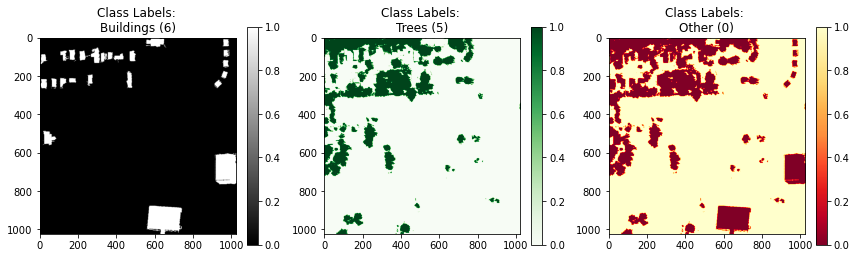

In [6]:
trainGroundTruth = vectorStackToImage(pd.DataFrame(groundTruthCLS,columns=['CLS']),colNames=['CLS'])

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
img = ax[0].imshow((trainGroundTruth['CLS'][imgIdx]==6).astype(np.uint8), cmap='gray'); ax[0].set_title('Class Labels: \nBuildings (6)'); fig.colorbar(img, ax=ax[0], fraction=0.05)
img = ax[1].imshow((trainGroundTruth['CLS'][imgIdx]==5).astype(np.uint8), cmap='Greens'); ax[1].set_title('Class Labels: \nTrees (5)'); fig.colorbar(img, ax=ax[1], fraction=0.05)
img = ax[2].imshow((trainGroundTruth['CLS'][imgIdx]==0).astype(np.uint8), cmap='YlOrRd_r'); ax[2].set_title('Class Labels: \nOther (0)'); fig.colorbar(img, ax=ax[2], fraction=0.05)
fig.tight_layout()
plt.savefig('./plots/rawDataCLSReduced.svg')

plt.show()

## Options:
- Use best classifier from HW2, get labels and instance segment (bounding box regression)
- YOLOv3 or Mask R-CNN: Ignore best classifier from HW2, use ground truth labels as target, segment usin U-Net or R-CNN

In [7]:
del rawDataTrain

In [8]:
YTrain = pd.DataFrame(groundTruthCLS,columns=['CLS'])['CLS']
dataTrain = dataTrain.drop(columns=dataTrain.columns[-1])

In [9]:
randomNumbers = np.random.permutation(len(dataTrain))[0:100000]
XTrain = dataTrain.iloc[randomNumbers]
YTrain = YTrain.iloc[randomNumbers]

from sklearn.ensemble import RandomForestClassifier

classifiers = [('Random Forest', RandomForestClassifier(n_estimators=100,criterion='entropy',
                                                        min_samples_split=200,min_samples_leaf=50,
                                                        bootstrap=True) ) ] 

## Train All Classifiers
for idx,clfTuple in enumerate(classifiers):
    print('\n##########################################################################\n')
    name = clfTuple[0]
    clf = clfTuple[1]
    print('{}:\n\t{}'.format(name,clf))
    
    # Train Classifier
    start = time.time()
    clf.fit(XTrain,YTrain)
    end = time.time()
    print('\tTraining time: {} seconds'.format(end-start))
    
    dump(clf,'./finalClassifiers/clf{}.joblib'.format(name))   ## store classifier for future use
    
    # Predictions and score on training set
    predictionsTrain = clf.predict(XTrain)
    scoreTrain = clf.score(XTrain,YTrain)

    print('Score [training set]: {}'.format(scoreTrain))


##########################################################################

Random Forest:
	RandomForestClassifier(criterion='entropy', min_samples_leaf=50,
                       min_samples_split=200)
	Training time: 48.47197461128235 seconds
Score [training set]: 0.91353


## Test Model

In [ ]:
del dataTrain, XTrain, YTrain

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from osgeo import gdal    ## used to read images in memory

import tensorflow as tf

################################################################
## Storing and timing Models
import pickle
from joblib import dump,load
import time

################################################################
# Custom functions from lib.py
from lib import dataExtract, dataStack, indicesFromDataStack, \
                stochasticPCAFromDataStack, stochasticICAFromDataStack, \
                stackToImage, featuresCompute, \
                vectorStackToImage

################################################################
import warnings
warnings.filterwarnings("ignore")

################################################################

In [2]:
colNames = ['coastal','blue','green','yellow','red','red edge','near IR1', 'near IR2','AGL','CLS']
rawDataTest = dataExtract(foldername='Final_project_test')
dataTest = pd.DataFrame(dataStack(rawDataTest) , columns=colNames)
del rawDataTest
## Compute features
dataTest = featuresCompute(dataTest, numPCA=3, numICA=3 )
dataTest = dataTest.fillna(0)

# Remove targets other than trees and buildings
groundTruthTestCLS = np.array(dataTest['CLS'])
groundTruthTestCLS[np.where(groundTruthTestCLS==9)[0]] = 2
groundTruthTestCLS[np.where(groundTruthTestCLS==17)[0]] = 2
groundTruthTestCLS[np.where(groundTruthTestCLS==65)[0]] = 2
groundTruthTestCLS[np.where(groundTruthTestCLS==2)[0]] = 0

YTest = pd.DataFrame(groundTruthTestCLS,columns=['CLS'])['CLS']
XTest = dataTest.drop(columns=dataTest.columns[-1])
del dataTest

Computed Principal Components
Computed Independent Components
	Computed NDVI: Normalized Difference Vegetation Index
	Computed NDWI: Normalized Difference Water Index
	Computed BAI: Burned Area Index
	Computed BNDVI: Blue Normalized Difference Vegetation Index
	Computed CVI: Chlorophyll Vegetation Index
	Computed GNDVI: Green Normalized Difference Vegetation Index
	Computed YNDVI: Yellow Normalized Difference Vegetation Index
	Computed OSAVI: Optimized Soil-Adjusted Vegetation Index
Computed Indices


In [3]:
for idx,clfname in enumerate(os.listdir('./finalClassifiers')):
    name = clfname
    clf = load('./finalClassifiers/{}'.format(clfname))
    # Predictions and score on training set
    predictionsTest = clf.predict(XTest)
    scoreTest = clf.score(XTest,YTest)
    print('{}: Score [testing set]: {}'.format(name,scoreTest))
     

clfRandom Forest.joblib: Score [testing set]: 0.8837631225585938


Overall Accuracy: 0.884
User's Accuracy: [0.945 0.773 0.731]
Producer's Accuracy: [0.926 0.804 0.768]
Kappa Coefficient: 0.758

#################################################################



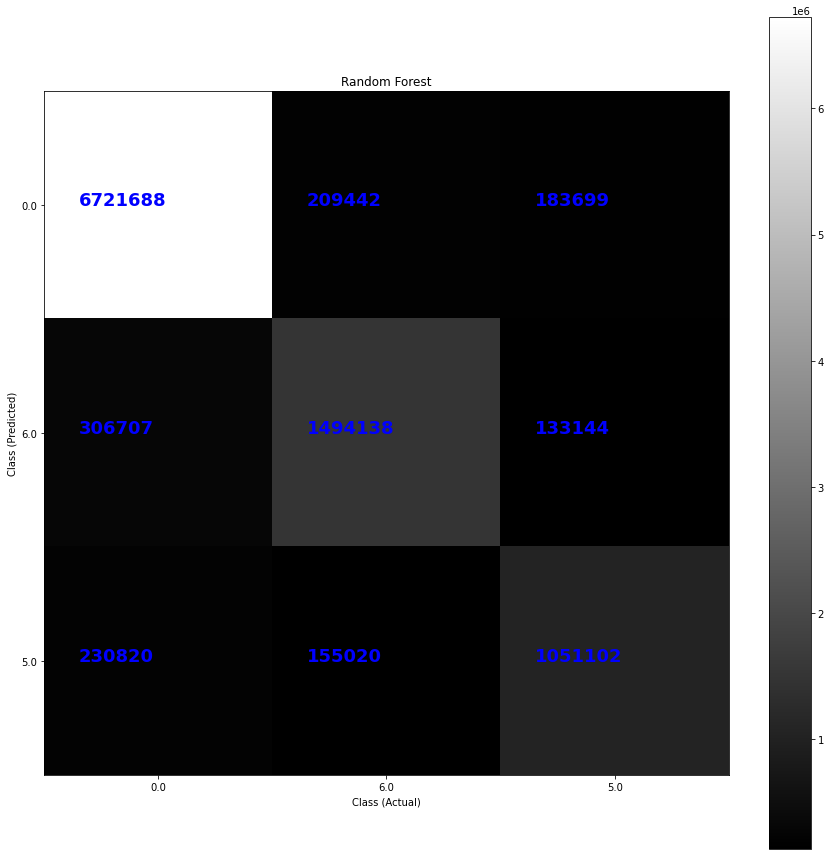

In [4]:
from lib import confusionMatrix, metrics, cMatrixPlots
cMatrix = confusionMatrix(predictionsTest,YTest)

overallAccuracy, userAccuracy, producerAccuracy, kappaCoeff = metrics(cMatrix)
print('Classes: {}'.format())
print('Overall Accuracy: {}'.format(np.round(overallAccuracy,3)))
print("User's Accuracy: {}".format(np.round(userAccuracy,3)))
print("Producer's Accuracy: {}".format(np.round(producerAccuracy,3)))
print('Kappa Coefficient: {}'.format(np.round(kappaCoeff,3)))
print('\n#################################################################\n')

cMatrixPlots(cMatrix,YTest,'Random Forest')
plt.show()

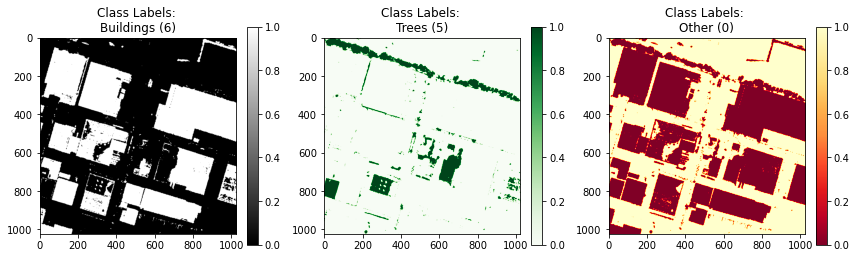

In [5]:
predictedClassImages = vectorStackToImage(pd.DataFrame(predictionsTest,columns=['CLS']),colNames=['CLS'])

imgIdx = 1

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
img = ax[0].imshow((predictedClassImages['CLS'][imgIdx]==6).astype(np.uint8), cmap='gray'); ax[0].set_title('Class Labels: \nBuildings (6)'); fig.colorbar(img, ax=ax[0], fraction=0.05)
img = ax[1].imshow((predictedClassImages['CLS'][imgIdx]==5).astype(np.uint8), cmap='Greens'); ax[1].set_title('Class Labels: \nTrees (5)'); fig.colorbar(img, ax=ax[1], fraction=0.05)
img = ax[2].imshow((predictedClassImages['CLS'][imgIdx]==0).astype(np.uint8), cmap='YlOrRd_r'); ax[2].set_title('Class Labels: \nOther (0)'); fig.colorbar(img, ax=ax[2], fraction=0.05)
fig.tight_layout()
plt.savefig('./plots/predictedCLSReduced.svg')

plt.show()


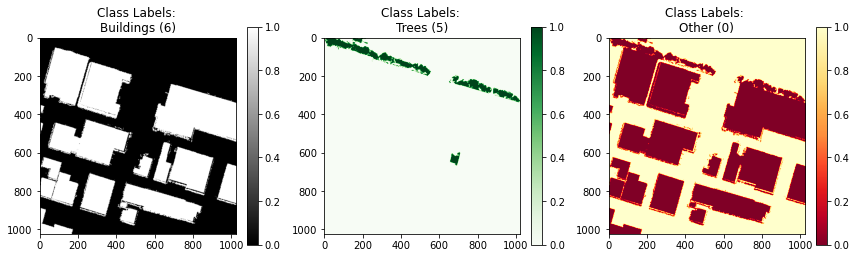

In [6]:
groundTruthTestClassImages = vectorStackToImage(pd.DataFrame(YTest,columns=['CLS']),colNames=['CLS'])

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
img = ax[0].imshow((groundTruthTestClassImages['CLS'][imgIdx]==6).astype(np.uint8), cmap='gray'); ax[0].set_title('Class Labels: \nBuildings (6)'); fig.colorbar(img, ax=ax[0], fraction=0.05)
img = ax[1].imshow((groundTruthTestClassImages['CLS'][imgIdx]==5).astype(np.uint8), cmap='Greens'); ax[1].set_title('Class Labels: \nTrees (5)'); fig.colorbar(img, ax=ax[1], fraction=0.05)
img = ax[2].imshow((groundTruthTestClassImages['CLS'][imgIdx]==0).astype(np.uint8), cmap='YlOrRd_r'); ax[2].set_title('Class Labels: \nOther (0)'); fig.colorbar(img, ax=ax[2], fraction=0.05)
fig.tight_layout()
plt.savefig('./plots/groundTruthTestCLSReduced.svg')

plt.show()


In [7]:
predictedClassImages['CLS'][1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.]])

## Bbox using skimage

In [8]:
predictedClassImages = np.array([predictedClassImages['CLS'][i] for i in range(len(predictedClassImages['CLS']))])

In [9]:
predictedClassImages = predictedClassImages.astype(np.uint8)
predictedClassImages[np.where(predictedClassImages==0)] = 0
predictedClassImages[np.where(predictedClassImages==5)] = 1
predictedClassImages[np.where(predictedClassImages==6)] = 2

In [10]:
predBackground = (predictedClassImages==0).astype(np.uint8)
predTree = (predictedClassImages==1).astype(np.uint8)
predBuilding = (predictedClassImages==2).astype(np.uint8)

In [11]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches

def draw_bbox(img_bboxCompute,backgroundImg,ax,color='red'):
    bw = closing(img_bboxCompute, square(3))
    
    # remove artifacts connected to image border
    # cleared = clear_border(bw)
    cleared = bw
    # label image regions
    label_image = label(cleared)
    
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 50:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor=color, linewidth=2)
            ax.add_patch(rect)

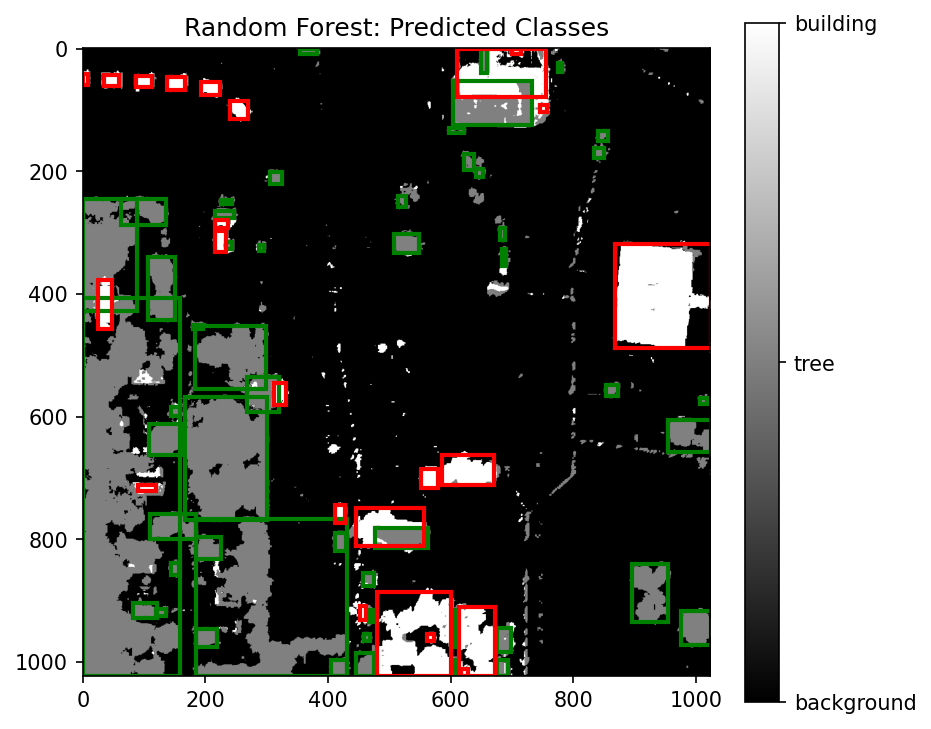

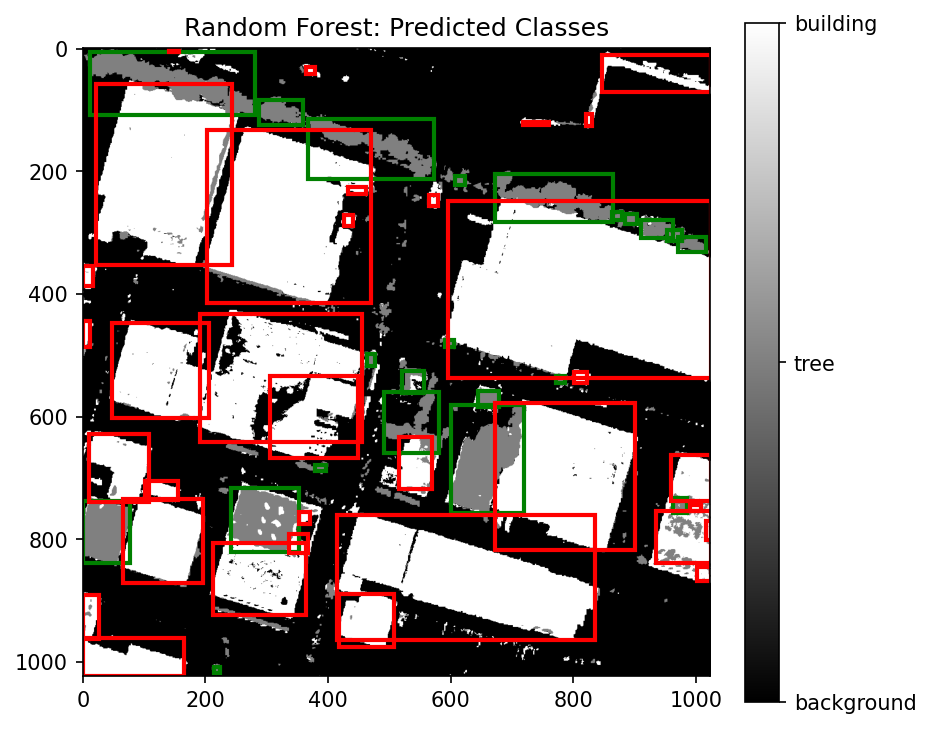

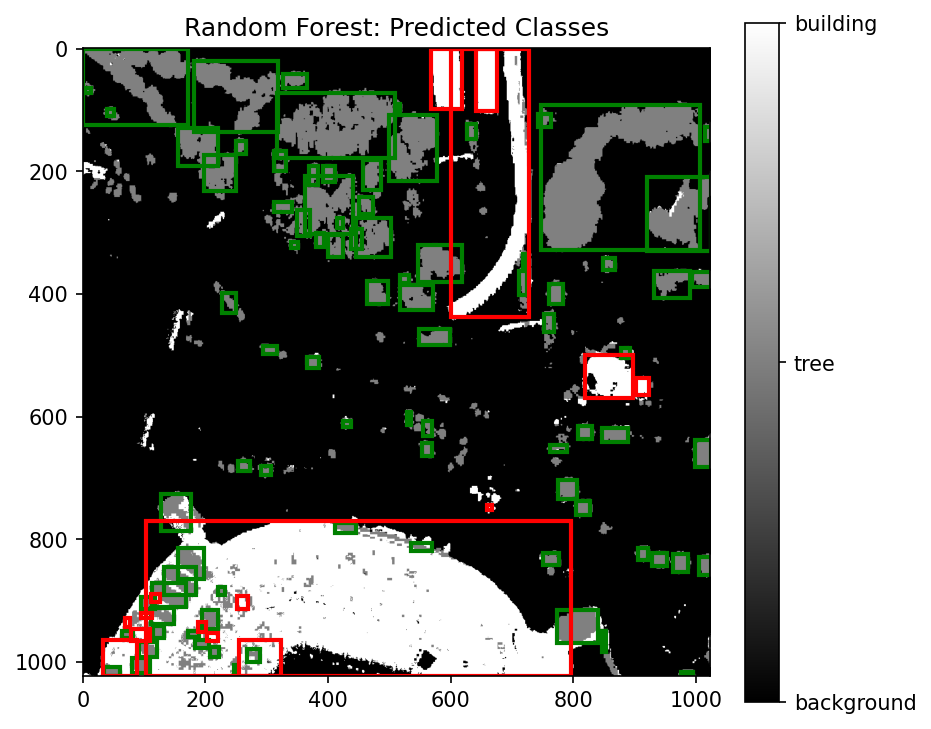

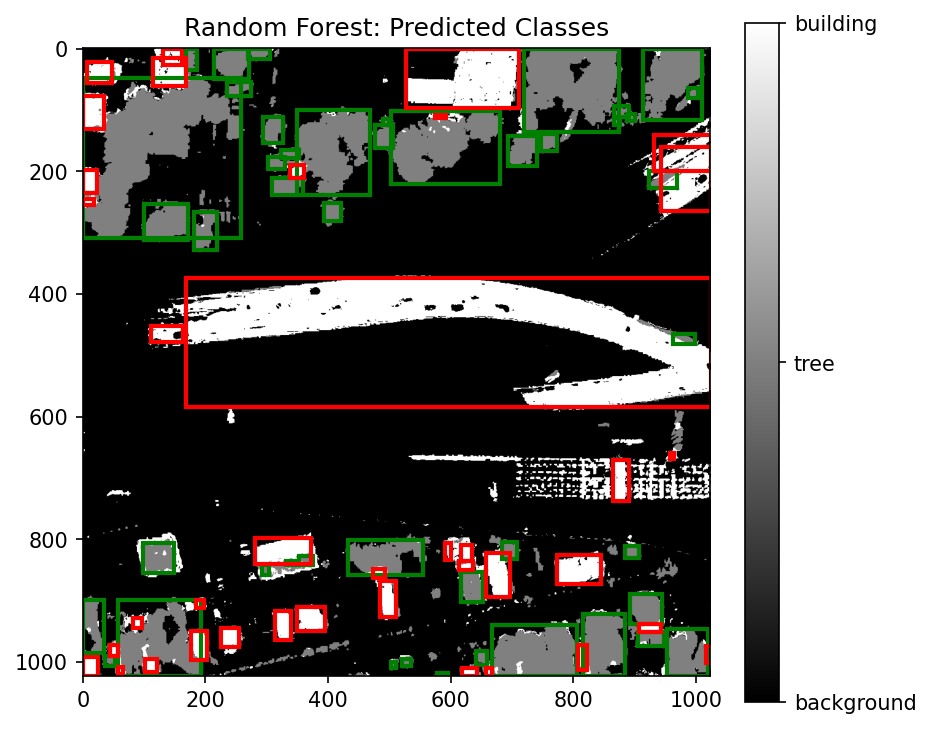

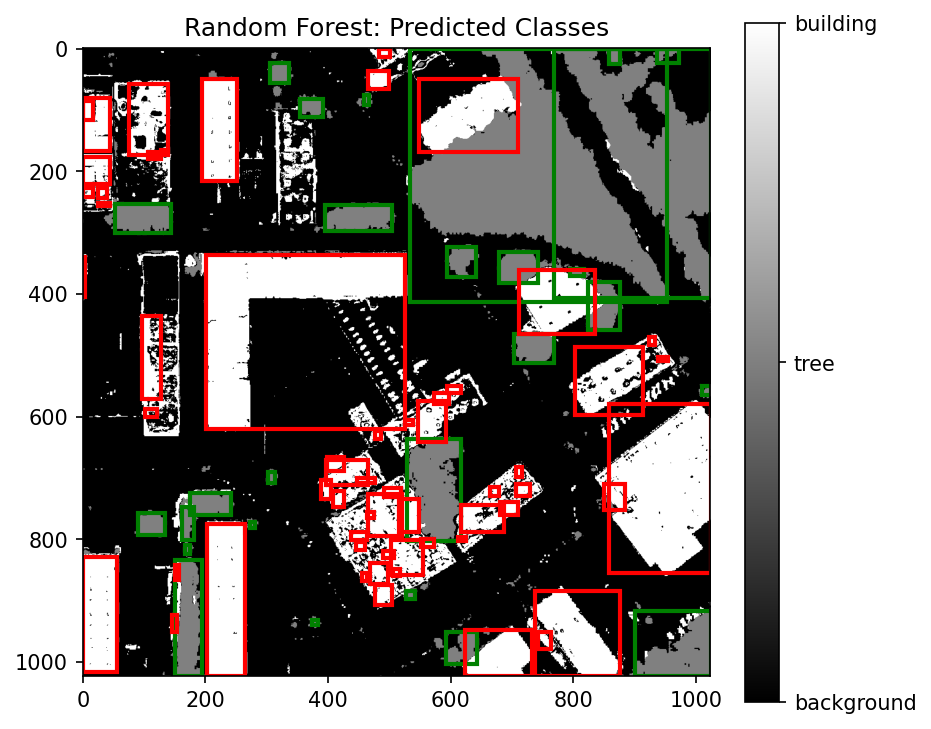

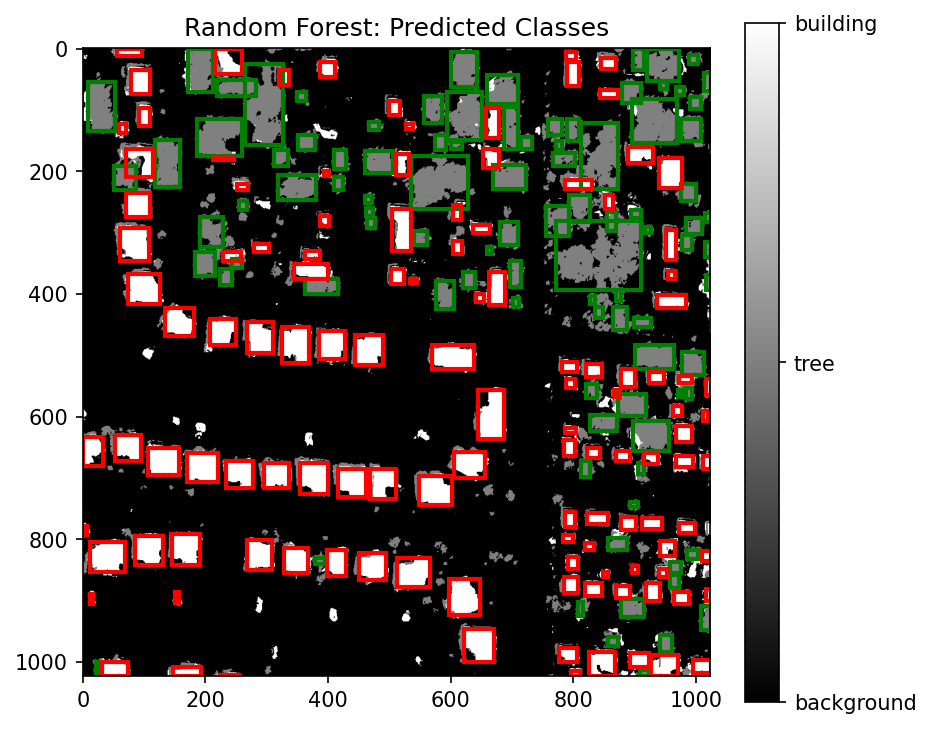

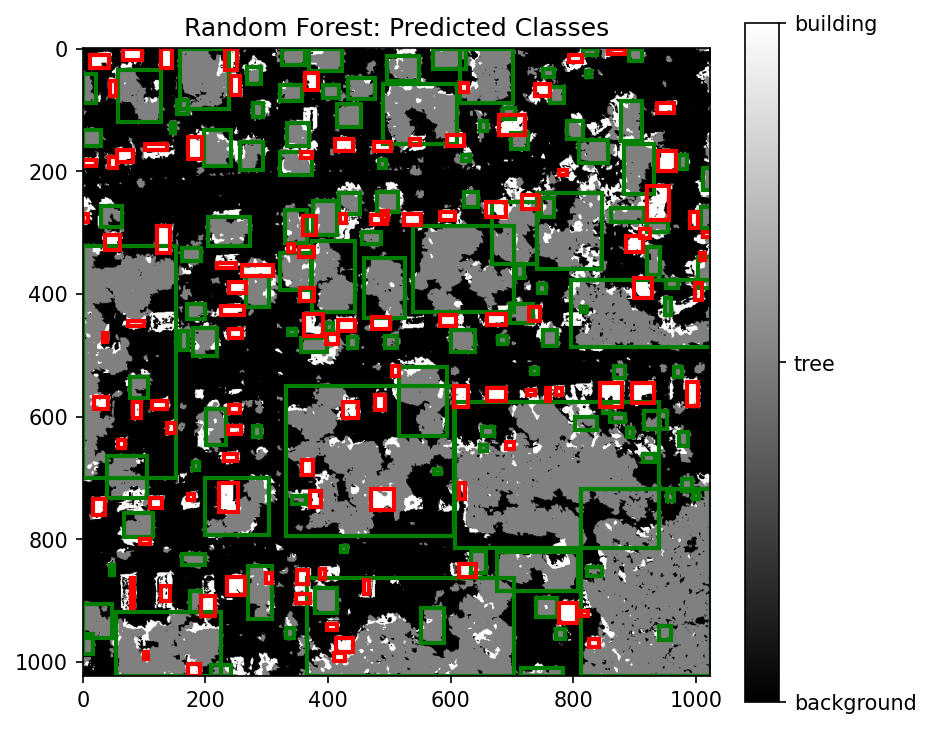

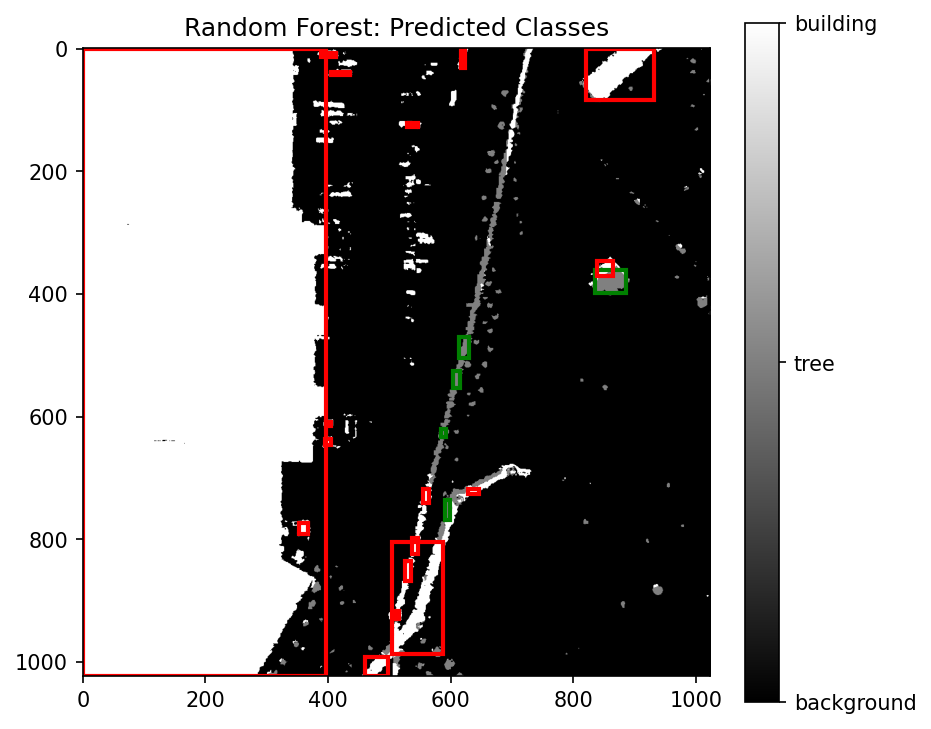

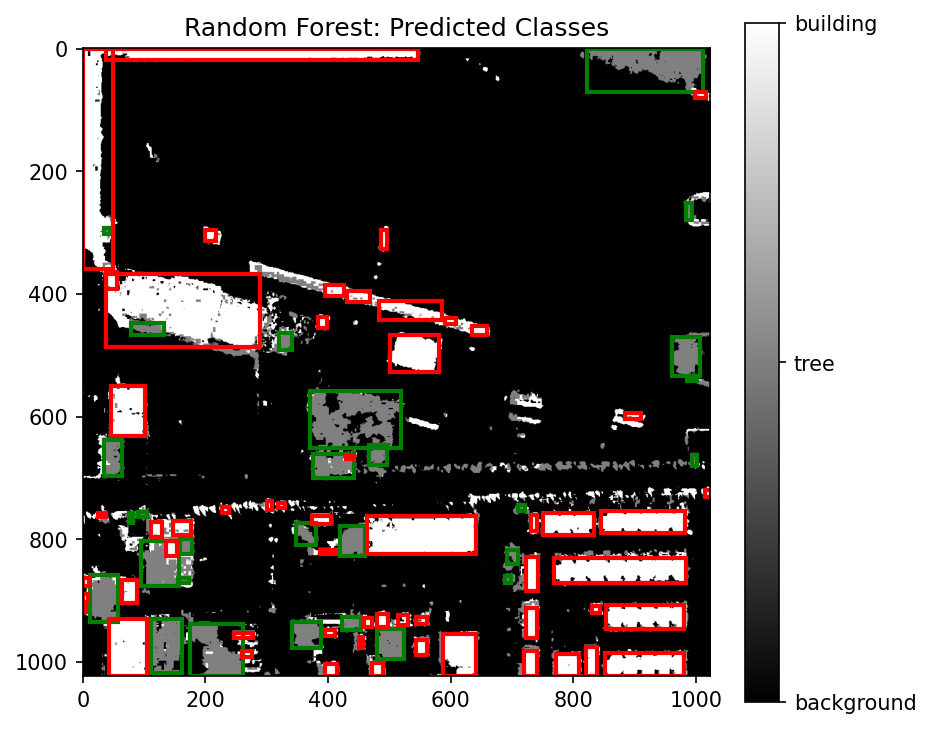

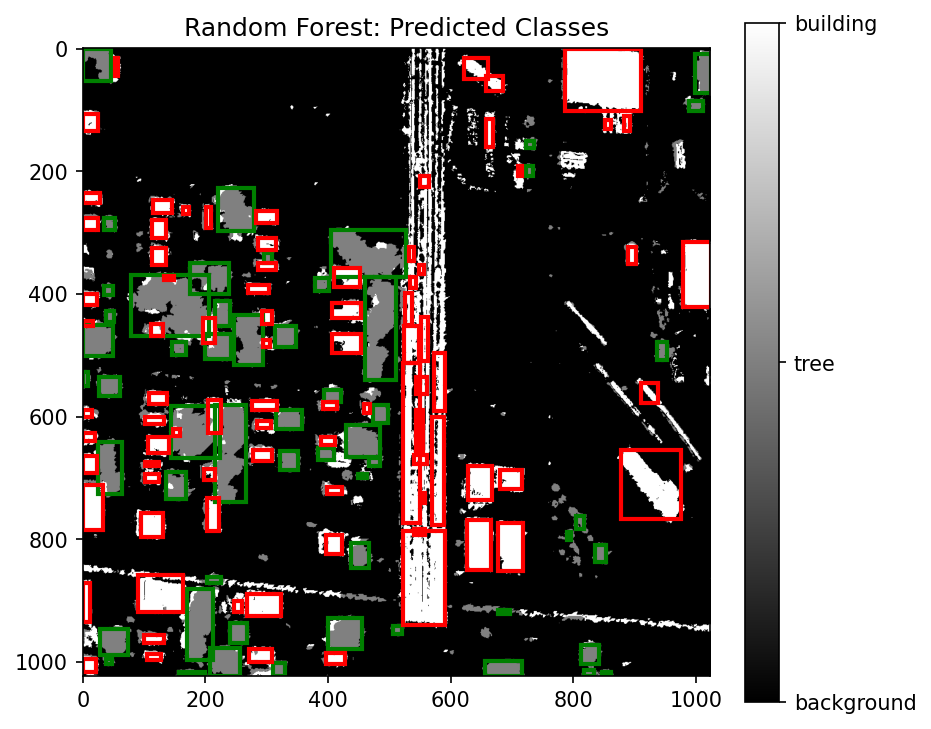

In [12]:
predImgInt = 0*predBackground + 1*predTree + 2*predBuilding

for i in range(predImgInt.shape[0]):
    kernel = np.ones((7,7),np.uint8)
    erosionTree = cv2.erode(predTree[i], kernel)
    erosionBuilding = cv2.erode(predBuilding[i], kernel)

    fig, ax = plt.subplots(dpi=150,figsize=(6,6))
    cax = ax.imshow(predImgInt[i], cmap='gray')
    ax.set_title('Random Forest: Predicted Classes')
    cbar = fig.colorbar(cax, ticks=[0, 1, 2],fraction=0.05)
    cbar.ax.set_yticklabels(['background', 'tree', 'building'])  # vertically oriented colorbar
    draw_bbox(img_bboxCompute=erosionTree,backgroundImg=predImgInt[i],ax=ax,color='green')
    draw_bbox(img_bboxCompute=erosionBuilding,backgroundImg=predImgInt[i],ax=ax,color='red')
    plt.savefig('./plots/bbox/ValidationImg_{}.svg'.format(i))
    plt.show()

In [13]:
groundTruthTestClassImages = np.array([groundTruthTestClassImages['CLS'][i] for i in range(len(groundTruthTestClassImages['CLS']))])
groundTruthTestClassImages = groundTruthTestClassImages.astype(np.uint8)
groundTruthTestClassImages[np.where(groundTruthTestClassImages==0)] = 0
groundTruthTestClassImages[np.where(groundTruthTestClassImages==5)] = 1
groundTruthTestClassImages[np.where(groundTruthTestClassImages==6)] = 2
actualBackground = (groundTruthTestClassImages==0).astype(np.uint8)
actualTree = (groundTruthTestClassImages==1).astype(np.uint8)
actualBuilding = (groundTruthTestClassImages==2).astype(np.uint8)

In [14]:
actualImgInt = 0*actualBackground + 1*actualTree + 2*actualBuilding

In [15]:
treeIntersection = predTree*actualTree
treeUnion = ((predTree+actualTree)>0).astype(np.uint8)

In [16]:
buildingIntersection = predBuilding*actualBuilding
buildingUnion = ((predBuilding+actualBuilding)>0).astype(np.uint8)

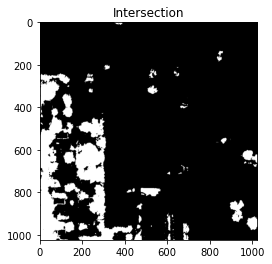

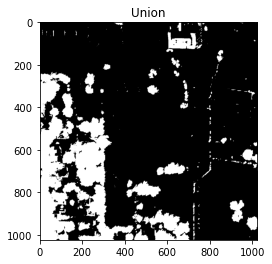

In [17]:
plt.figure()
plt.imshow(treeIntersection[0],cmap='gray')
plt.title('Intersection')
plt.figure()
plt.imshow(treeUnion[0],cmap='gray')
plt.title('Union')
plt.show()

In [18]:
for i in range(len(actualImgInt)):
    print(f"\nImage {i}")
    print(f"IOU (Trees): {np.sum(treeIntersection[i])/np.sum(treeUnion[i])}")
    print(f"IOU (Building): {np.sum(buildingIntersection[i])/np.sum(buildingUnion[i])}")

# iouImg = np.nan_to_num((treeIntersection/treeUnion)[0],nan=0)
# plt.figure()
# plt.imshow((buildingIntersection/buildingUnion)[0],cmap='gray')


Image 0
IOU (Trees): 0.6501597444089456
IOU (Building): 0.37669122705564473

Image 1
IOU (Trees): 0.3131435707721671
IOU (Building): 0.8069545561041643

Image 2
IOU (Trees): 0.6183884212324531
IOU (Building): 0.6635533868201536

Image 3
IOU (Trees): 0.6508578702348012
IOU (Building): 0.23603035201582745

Image 4
IOU (Trees): 0.8379874241299506
IOU (Building): 0.658025889435334

Image 5
IOU (Trees): 0.5064118844983398
IOU (Building): 0.6307675819588908

Image 6
IOU (Trees): 0.6484590781140818
IOU (Building): 0.4416319649754048

Image 7
IOU (Trees): 0.19200044074706626
IOU (Building): 0.9469538761352073

Image 8
IOU (Trees): 0.36008865956905634
IOU (Building): 0.503073894000884

Image 9
IOU (Trees): 0.5225816317613818
IOU (Building): 0.443435362066397


In [19]:
print(f"IOU (Trees): {np.sum(treeIntersection)/np.sum(treeUnion)}")
print(f"IOU (Building): {np.sum(buildingIntersection)/np.sum(buildingUnion)}")

IOU (Trees): 0.5993334416704442
IOU (Building): 0.6500630207039436
